# Linear Regression Gradient Descent Stochastic , Minibatch , Batch 01FE20BCS411


In [ ]:
import numpy as np
import torch
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
from IPython.display import Image
import pickle
import logging
import time
import random
from enum import Enum

In [ ]:
# we define our log repository
# LOG_REPOSITORY = "./logs/"

# and we configure our logger
# logging.basicConfig(filename = LOG_REPOSITORY + 'linear-regression-GradientDescent-Hardcoded.log', 
#                     format='%(asctime)s [%(levelname)s]: %(message)s', 
#                     level=logging.DEBUG)


In [ ]:
data = pd.read_csv("15.csv", delimiter=',', low_memory=False)
data.fillna(0,inplace=True)
data = data.sample(frac=1)
data.head()

In [ ]:
data.describe()

In [ ]:
from numpy import genfromtxt

my_data = genfromtxt('15.csv', delimiter=',')
# print(my_data)
t=torch.tensor(my_data)
print(t)


In [ ]:
# torch_X = torch.tensor(data['X'].values)
# torch_Y = torch.tensor(data['Y'].values)

In [ ]:
# print(torch_X)

In [ ]:
# print(torch_Y)

In [53]:
columns = ['X','Y']
filteredColumns = data[columns]
filteredColumns.describe()

,X,Y
count,600.000000,600.000000
mean,8.881657,18.002670
std,1.988464,1.157617
min,1.161959,15.069422
25%,7.547416,17.212016
50%,8.915307,17.953282
75%,10.309793,18.761367
max,14.523022,21.649420


We print a plot graph representing the data.

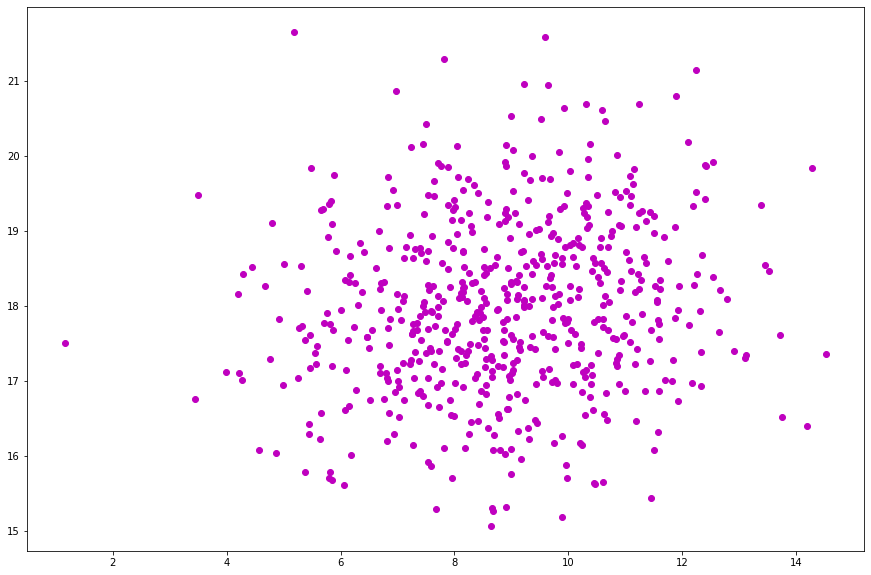

In [54]:
plt.figure(figsize=(15,10))
x = filteredColumns['X']
y = filteredColumns['Y']
plt.plot(x,y,'mo')

In [59]:
#splitting dataset
train_size = int(0.8 * len(t))
test_size = len(t) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(t, [train_size, test_size])

In [64]:
print(train_dataset)

In [55]:
# Calculate mean squared error
def mean_squared_error(actual_values, predicted_values):
    sum_value = .0
    for i in range(len(actual_values)):
        sum_value += ((predicted_values[i] - actual_values[i]) ** 2)
        
    return sum_value/float(len(actual_values))

In [ ]:
# calculate the gradient of one step
def step_gradient(x,y,b_current=0,m_current=0,learning_rate=.0001):
    N = float(len(x))
    m_gradient = 0
    b_gradient = 0
    for i in range(len(x)):
        b_gradient += -(2/N) * (y[i] - (m_current * x[i] + b_current))
        m_gradient += -(2/N) * x[i] * (y[i] - (m_current * x[i] + b_current))
    b_next = b_current - (learning_rate * b_gradient)
    m_next = m_current - (learning_rate * m_gradient)
    return b_next , m_next

In here, we are creating the gradient descent runner.

In [ ]:
# function to delete then print in a jupyter notebook
def only_print(text):
    clear_output()
    print(text)

# enumeartion for types of gradient descent
class GradientDescentTypes(Enum):
    Batch = 1
    Stochastic = 2
    MiniBatch = 3
    
# get a sample of the data
def get_sample(x,y,size,shuffle=False):
    if shuffle:
        c = list(zip(x, y))
        random.shuffle(c)
        x, y = zip(*c)
    
    x = pd.Series(list(x))
    y = pd.Series(list(y))
    
    x = x.iloc[:size]
    y = y.iloc[:size]
    
    x.index = range(size)
    y.index = range(size)
    
    return x, y
    
# function to run gradient descent for n iterations
def gradient_descent_runner(x,y,b_start=0,m_start=0,learning_rate=.0001,num_iteration=1000, 
                            learning_method=GradientDescentTypes.Batch, batch_size=256):
    b_now = b_start
    m_now = m_start
    mse = mean_squared_error(y, compute_linear_y_values(x,b_now, m_now))
    predictions = [[b_now,m_now,mse]]
    if(learning_method is GradientDescentTypes.Batch):
        for i in range(num_iteration):
            b_now, m_now = step_gradient(x,y,b_now,m_now,learning_rate)
            mse = mean_squared_error(y, compute_linear_y_values(x,b_now, m_now))
            predictions.append([b_now,m_now,mse])
            only_print("[b = {}, m = {}, mse = {}, iteration = {}]".format(b_now,m_now,mse,i))
            logging.info("[b = {}, m = {}, mse = {}, iteration = {}]".format(b_now,m_now,mse,i))
        return predictions
        
    elif(learning_method is GradientDescentTypes.Stochastic):
        for i in range(num_iteration):
            shuffle_x, shuffle_y = get_sample(x,y,1,shuffle=True)
            b_now, m_now = step_gradient(shuffle_x,shuffle_y,b_now,m_now,learning_rate)
            mse = mean_squared_error(y, compute_linear_y_values(x,b_now, m_now))
            predictions.append([b_now,m_now,mse])
            only_print("[b = {}, m = {}, mse = {}, iteration = {}]".format(b_now,m_now,mse,i))
            logging.info("[b = {}, m = {}, mse = {}, iteration = {}]".format(b_now,m_now,mse,i))
        return predictions
        
    elif(learning_method is GradientDescentTypes.MiniBatch):
        for i in range(num_iteration):
            shuffle_x, shuffle_y = get_sample(x,y,batch_size,shuffle=True)
            b_now, m_now = step_gradient(shuffle_x,shuffle_y,b_now,m_now,learning_rate)
            mse = mean_squared_error(y, compute_linear_y_values(x,b_now, m_now))
            predictions.append([b_now,m_now,mse])
            only_print("[b = {}, m = {}, mse = {}, iteration = {}]".format(b_now,m_now,mse,i))
            logging.info("[b = {}, m = {}, mse = {}, iteration = {}]".format(b_now,m_now,mse,i))
        return predictions
    else:
        return []

In [ ]:
# function for splitting the data into training and testing
def split_data(x,train_split_rate = .3):
    train_x = x.iloc[:int(round(len(x)*train_split_rate))]
    test_x = x.iloc[int(round(len(x)*train_split_rate)):]
    
    train_x.index = range(len(train_x))
    test_x.index = range(len(test_x))
    
    return train_x, test_x

In [ ]:
# hyperparameters
epochs = 100
b_start = 0
m_start = 0
learning_rate = .0005

In [ ]:
# splitting the data
# import torch.utils.data as data_utils
# train = data_utils.TensorDataset(torch.Tensor(np.array(data)))
# train_data, test_data = split_data(train,train_split_rate=.5)
# train_x, test_x = train_data['X'], test_data['X']
# train_y, test_y = train_data['Y'], test_data['Y']

In [74]:
def compute_linear_y_values(x,b = 0,m = 0):
    result = b + (m * x)
    return result

We now compute our predictions.

In [65]:
predictions = gradient_descent_runner(train_x,train_y,b_start,m_start,learning_rate,epochs)

# if you want to load a saved data just execute the following
# predictions = get_from_file('prediction_array.pkl')

[b = 0.28084472596227605, m = 1.9195990798107327, mse = 13.729016941389276, iteration = 99]


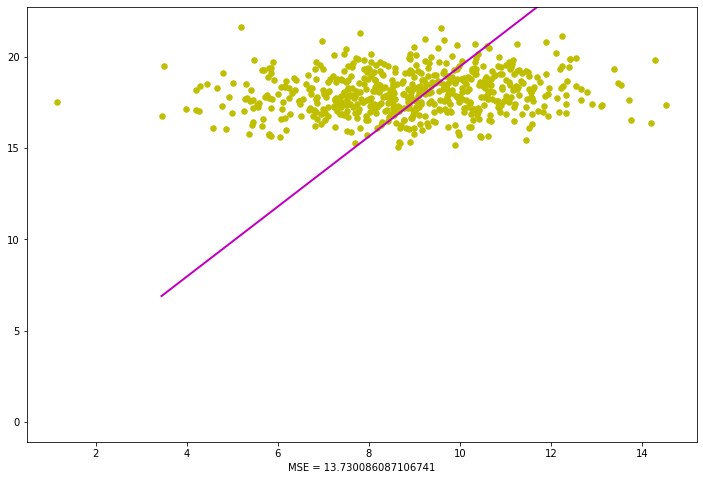

In [78]:

# plot parameters
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,color = "y", marker = "o", s = 30)
x_line = pd.Series([min(train_x),max(train_x)])
x_line.index = range(int(len(x_line)))
ln, = ax.plot(x_line, compute_linear_y_values(x_line,b_start,m_start), color = "m", linewidth=2, animated = True)

# initialisation of plot data
def init_function():
    ln.set_data(x_line, compute_linear_y_values(x_line,b_start,m_start))
    #predictions = gradient_descent_runner(x,y,b_start,m_start,learning_rate,epochs)
    return ln,
    
# the update function of our animation
def update_function(frame):
    y_predicted = compute_linear_y_values(x_line,predictions[frame][0], predictions[frame][1])
    ln.set_ydata(y_predicted)
    #mse = mean_squared_error(train_y, y_predicted)
    ax.set_xlabel("MSE = {}".format(predictions[frame][2]))
    return ln,

anim = FuncAnimation(fig, update_function, epochs, blit=False, interval=1,
                              repeat=True, init_func=init_function)

#save the plot as a gif
anim.save('./animations/linear-regression1.gif', dpi=80, writer='imagemagick')

clear_output()

We print now the Mean Squared Error.

In [67]:
max_index = int(len(predictions)-1)
last_b, last_m = predictions[max_index][0], predictions[max_index][1]
test_result = compute_linear_y_values(test_x,last_b,last_m)
mse = mean_squared_error(test_y, test_result)
print("Testing MSE = {}".format(mse))

Testing MSE = 16.595283732384633


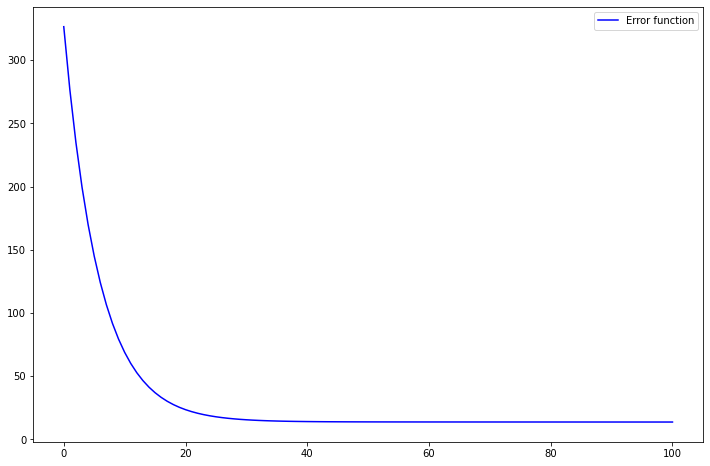

In [77]:
plt.subplots(figsize=(12,8))
x_values = [i for i in range(len(predictions))]
y_values = [m[2] for m in predictions]
plt.plot(x_values, y_values, color = "b", label="Error function")
plt.legend()
plt.show()


In [ ]:
# print(predictions)

In [69]:
# batch gradient descent
start_time = time.time()
predictions_batch = gradient_descent_runner(train_x,train_y,b_start,m_start,learning_rate,epochs, 
                                      learning_method=GradientDescentTypes.Batch)
passed_time_batch = time.time() - start_time

# stochastic gradient descent
start_time = time.time()
predictions_stochastic = gradient_descent_runner(train_x,train_y,b_start,m_start,learning_rate,epochs, 
                                      learning_method=GradientDescentTypes.Stochastic)
passed_time_stochastic = time.time() - start_time

# mini-batch gradient descent
start_time = time.time()
predictions_miniBatch = gradient_descent_runner(train_x,train_y,b_start,m_start,learning_rate,epochs, 
                                      learning_method=GradientDescentTypes.MiniBatch,batch_size=256)
passed_time_miniBatch = time.time() - start_time

[b = 0.28089194319768235, m = 1.9203747942267437, mse = 13.729077662954836, iteration = 99]


In [70]:
print('time passed with batch: {}'.format(passed_time_batch))
print('time passed with stochastic: {}'.format(passed_time_stochastic))
print('time passed with mini-batch: {}'.format(passed_time_miniBatch))

time passed with batch: 0.6173508167266846
time passed with stochastic: 0.27513837814331055
time passed with mini-batch: 0.6031913757324219


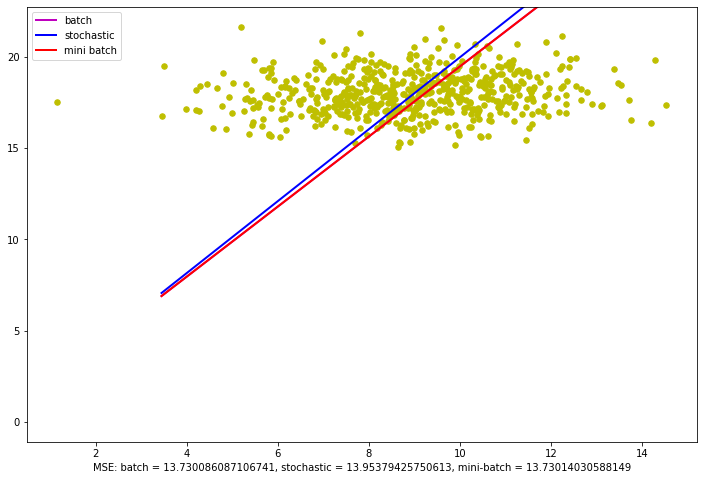

In [71]:
# plot parameters
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x,y,color = "y", marker = "o", s = 30)
x_line = pd.Series([min(train_x),max(train_x)])
x_line.index = range(int(len(x_line)))
ln_batch, = ax.plot(x_line, compute_linear_y_values(x_line,b_start,m_start), color = "m", linewidth=2, 
                    animated = True, label="batch")
ln_stochastic, = ax.plot(x_line, compute_linear_y_values(x_line,b_start,m_start), color = "b", linewidth=2, 
                         animated = True, label="stochastic")
ln_mini_batch, = ax.plot(x_line, compute_linear_y_values(x_line,b_start,m_start), color = "r", linewidth=2, 
                         animated = True,label="mini batch")

ax.legend()

# initialisation of plot data
def init_function():
    ln_batch.set_data(x_line, compute_linear_y_values(x_line,b_start,m_start))
    ln_stochastic.set_data(x_line, compute_linear_y_values(x_line,b_start,m_start))
    ln_mini_batch.set_data(x_line, compute_linear_y_values(x_line,b_start,m_start))
    return ln,
    
# the update function of our animation
def update_function(frame):
    y_predicted_batch = compute_linear_y_values(x_line,predictions_batch[frame][0], predictions_batch[frame][1])
    ln_batch.set_ydata(y_predicted_batch)
    y_predicted_stochastic = compute_linear_y_values(x_line,predictions_stochastic[frame][0], predictions_stochastic[frame][1])
    ln_stochastic.set_ydata(y_predicted_stochastic)
    y_predicted_mini_batch = compute_linear_y_values(x_line,predictions_miniBatch[frame][0], predictions_miniBatch[frame][1])
    ln_mini_batch.set_ydata(y_predicted_mini_batch)
    #mse = mean_squared_error(train_y, y_predicted)
    ax.set_xlabel("MSE: batch = {}, stochastic = {}, mini-batch = {}".format(predictions_batch[frame][2],
                                                                            predictions_stochastic[frame][2],
                                                                            predictions_miniBatch[frame][2]))
    return ln,

anim = FuncAnimation(fig, update_function, epochs, blit=False, interval=1,
                              repeat=True, init_func=init_function)

#save the plot as a gif
anim.save('./animations/linear-regression.gif', dpi=80, writer='imagemagick')

clear_output()

And lastly, we print a nice plot representing our loss function.

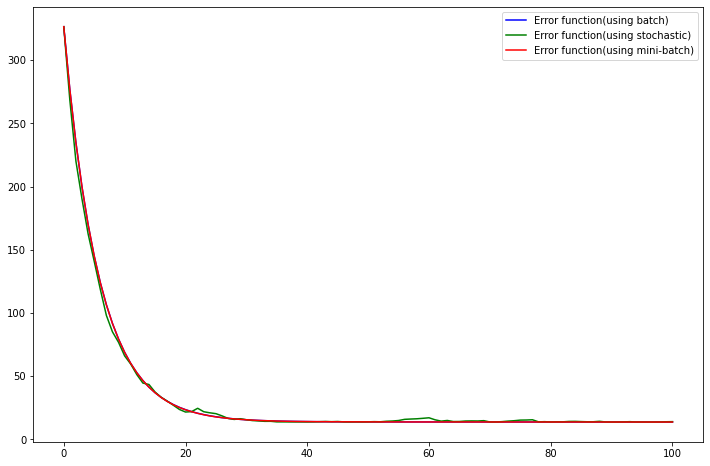

In [76]:
plt.subplots(figsize=(12,8))
x_values = [i for i in range(len(predictions))]
y_values = [m[2] for m in predictions_batch]
plt.plot(x_values, y_values, color = "b", label="Error function(using batch)")
plt.legend()
y_values = [m[2] for m in predictions_stochastic]
plt.plot(x_values, y_values, color = "g", label="Error function(using stochastic)")
plt.legend()
y_values = [m[2] for m in predictions_miniBatch]
plt.plot(x_values, y_values, color = "r", label="Error function(using mini-batch)")
plt.legend()
plt.show()